### Interface planner with sim_env

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import numpy as np
from PIL import Image

from unified_planning.shortcuts import *
from unified_planning.io import PDDLReader
up.shortcuts.get_env().credits_stream = None # Disable print of credits

import bddl
from igibson.action_primitives.fetch_robot_semantic_actions_env import FetchRobotSemanticActionEnv
from igibson.custom_utils import get_env_config, print_properties
import igibson.render_utils as render_utils

from planning_utils import print_symbolic_state, execute_plan, translate_str_to_dict

import warnings
warnings.filterwarnings("ignore")


 _   _____  _  _
(_) / ____|(_)| |
 _ | |  __  _ | |__   ___   ___   _ __
| || | |_ || || '_ \ / __| / _ \ | '_ \
| || |__| || || |_) |\__ \| (_) || | | |
|_| \_____||_||_.__/ |___/ \___/ |_| |_|



/miniconda/envs/igibson/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Run only planner on all problems of a split


In [9]:
### Common setups ###
pddl_dir = 'pddl' 
domain_file = os.path.join(pddl_dir,'domain.pddl')
reader = PDDLReader()

easy_filename = 'easy_split_metadata.json'

with open(easy_filename) as f:
    easy_split_metadata = json.load(f)

### Task loop ###
for entry in easy_split_metadata:

    ### PDDL part ###
    pddl_problem_file = 'pddl/easy/'+entry
    
    # Parse problem and domain
    problem = reader.parse_problem(domain_file, pddl_problem_file)
        
    # Make a plan for the problem
    with OneshotPlanner(problem_kind=problem.kind) as planner:
        result = planner.solve(problem)
    
    # Check if planner found a plan
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Plan found.")
        # Prepare plan in the right format
        plan = [translate_str_to_dict(str(action)) for action in result.plan.actions]
        for action in plan:
            print(action)
    else:
        print("No plan found.")
        plan = []

    ### Sim_env part ###
    #task = easy_split_metadata[entry]["activity_name"]
    #for scene_id, instance_id in easy_split_metadata[entry]["scene_instance_pairs"]:
    #    print(f"Scene_id: {scene_id} - instance_id: {instance_id}")
    #
    #    # Init env
    #    sim_env = FetchRobotSemanticActionEnv(task, scene_id, instance_id, verbose=False)
    #    
    #    # Get initial state and show it
    #    image, symbolic_state = sim_env.get_state_and_image()
    #    image.show()
    #
    #    # Here goes the planning logic / benchmarking part
    #    # ...
    #    
    #    # Shut down gracefully to avoid memory leaks
    #    sim_env.env.clean()

Plan found.
{'action': 'navigate-to', 'params': ['toothbrush_1']}
{'action': 'navigate-to', 'params': ['backpack_1']}
{'action': 'open-container', 'params': ['backpack_1']}
{'action': 'navigate-to', 'params': ['toothbrush_1']}
{'action': 'grasp', 'params': ['toothbrush_1']}
{'action': 'navigate-to', 'params': ['backpack_1']}
{'action': 'place-inside', 'params': ['toothbrush_1', 'backpack_1']}
Plan found.
{'action': 'navigate-to', 'params': ['carton_1']}
{'action': 'open-container', 'params': ['carton_1']}
{'action': 'grasp', 'params': ['candle_1']}
{'action': 'navigate-to', 'params': ['table_1']}
{'action': 'place-on', 'params': ['candle_1', 'table_1']}
Plan found.
{'action': 'navigate-to', 'params': ['hardback_1']}
{'action': 'grasp', 'params': ['hardback_1']}
{'action': 'navigate-to', 'params': ['shelf_1']}
{'action': 'place-on', 'params': ['hardback_1', 'shelf_1']}
Plan found.
{'action': 'navigate-to', 'params': ['cabinet_1']}
{'action': 'open-container', 'params': ['cabinet_1']}
{'

### Run on all problems of a split

In [ ]:
### Common setups ###
pddl_dir = 'pddl' 
domain_file = os.path.join(pddl_dir,'domain.pddl')
reader = PDDLReader()

easy_filename = 'easy_split_metadata.json'

with open(easy_filename) as f:
    easy_split_metadata = json.load(f)

benchmark_results = {}  # Initialize result container
### Task loop ###
for entry in easy_split_metadata:
    task = easy_split_metadata[entry]["activity_name"]
    print("\n\n"+"-"*80)
    print(f"Executing task {task}")
    
    ### PDDL part ###
    pddl_problem_file = 'pddl/easy/'+entry
    
    # Parse problem and domain
    problem = reader.parse_problem(domain_file, pddl_problem_file)
        
    # Make a plan for the problem
    with OneshotPlanner(problem_kind=problem.kind) as planner:
        result = planner.solve(problem)
    
    # Check if planner found a plan
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Plan found.")
        # Prepare plan in the right format
        plan = [translate_str_to_dict(str(action)) for action in result.plan.actions]
        for action in plan:
            print(action)
    else:
        print("No plan found.")
        plan = []

    benchmark_results[task] = {}
    
    ### Sim_env part ###
    for task_instance, (scene_id, instance_id) in enumerate(easy_split_metadata[entry]["scene_instance_pairs"]):
        print(f"\nTask_instance: {task_instance} - scene_id: {scene_id} - instance_id: {instance_id}")
    
        # Init env
        sim_env = FetchRobotSemanticActionEnv(task, scene_id, instance_id, verbose=False)
        
        # Here goes the planning logic / benchmarking part
        plan_succeeded, plan_status = execute_plan(sim_env, plan, task, task_instance)

        # Save results in benchmark_results
        benchmark_results[task][task_instance] = {
            'scene_id': scene_id,
            'instance_id': instance_id,
            'plan_succeeded': plan_succeeded,
            'plan_status': plan_status
        }
        print(f"Plan succeeded: {plan_succeeded}.")
        print("Detailed plan breakdown: ", plan_status)
        
        # Shut down gracefully to avoid memory leaks
        sim_env.env.clean()

        break # do only a single instance per problem
    
# Save all benchmark results to disk
results_file = 'benchmark_results.json'
with open(results_file, 'w') as f:
    json.dump(benchmark_results, f, indent=2)

print(f"\nBenchmarking complete. Results saved to {results_file}")

### Dev

In [5]:
test_activity_file = 'pddl/easy/packing_food_for_work.pddl'
task, scene_id = get_task_and_scene(test_activity_file)
sim_env = FetchRobotSemanticActionEnv(task, scene_id, verbose=True)

trg_obj = sim_env.env.task.object_scope['apple.n.01_1'] 

Rendering settings is None - going with the default settings!


In [8]:
# PDDL configs
pddl_dir = 'pddl' 
domain_file = os.path.join(pddl_dir,'domain.pddl')
pddl_problem_file = 'pddl/easy/setting_up_candles_simple.pddl'
reader = PDDLReader()

# Env config - how to change this dynamically in accord with the pddl problem?
task = "setting_up_candles"
scene_id =  "Beechwood_0_int"

# Init env
sim_env = FetchRobotSemanticActionEnv(task, scene_id, instance_id=0, verbose=False)

Rendering settings is None - going with the default settings!


Plan found.
{'action': 'navigate-to', 'params': ['candle_1']}
{'action': 'grasp', 'params': ['candle_1']}
{'action': 'navigate-to', 'params': ['table_1']}
{'action': 'place-on', 'params': ['candle_1', 'table_1']}


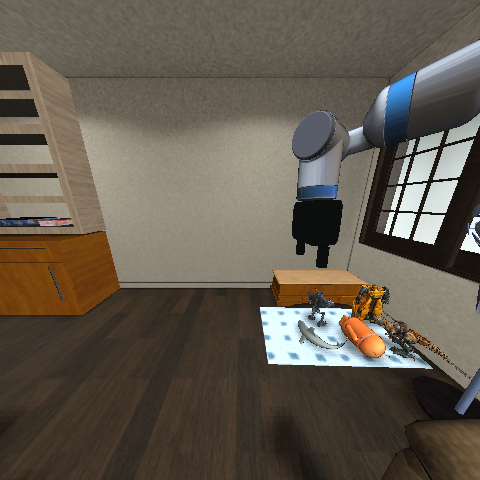

----------------------------------------------------------------------------
Symbolic state: 

reachable {}
holding {}
is_movable {'candle.n.01_1': True, 'candle.n.01_2': True, 'candle.n.01_3': True, 'candle.n.01_4': True, 'candle.n.01_5': True, 'candle.n.01_6': True}
open {'carton.n.02_1': True, 'carton.n.02_2': True}
ontop {'candle.n.01_1,carton.n.02_1': True, 'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
inside {'candle.n.01_1,carton.n.02_1': True, 'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
nextto {'candle.n.01_1,carton.n.02_1': True, 'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_

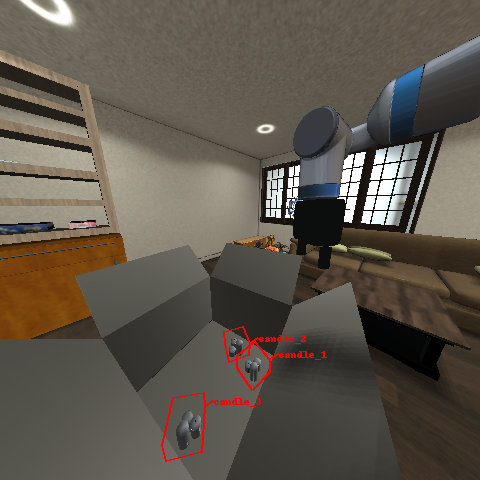

----------------------------------------------------------------------------
Symbolic state: 

reachable {'candle.n.01_1': True, 'candle.n.01_2': True, 'candle.n.01_3': True, 'carton.n.02_1': True}
holding {}
is_movable {'candle.n.01_1': True, 'candle.n.01_2': True, 'candle.n.01_3': True, 'candle.n.01_4': True, 'candle.n.01_5': True, 'candle.n.01_6': True}
open {'carton.n.02_1': True, 'carton.n.02_2': True}
ontop {'candle.n.01_1,carton.n.02_1': True, 'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
inside {'candle.n.01_1,carton.n.02_1': True, 'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
nextto {'candle.n.01_1,carton.n.02_1': True, 'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.0

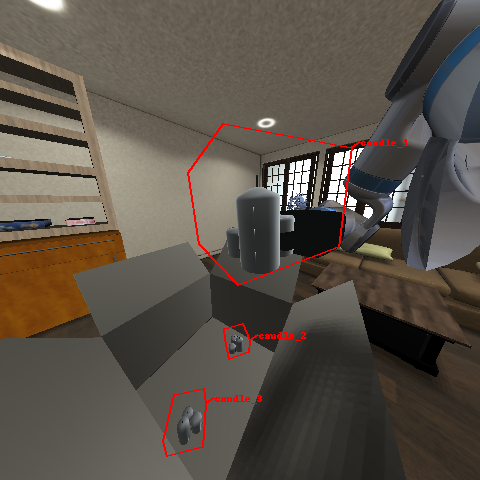

----------------------------------------------------------------------------
Symbolic state: 

reachable {'candle.n.01_1': True, 'candle.n.01_2': True, 'candle.n.01_3': True, 'carton.n.02_1': True}
holding {'candle.n.01_1': True}
is_movable {'candle.n.01_1': True, 'candle.n.01_2': True, 'candle.n.01_3': True, 'candle.n.01_4': True, 'candle.n.01_5': True, 'candle.n.01_6': True}
open {'carton.n.02_1': True, 'carton.n.02_2': True}
ontop {'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
inside {'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
nextto {'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_

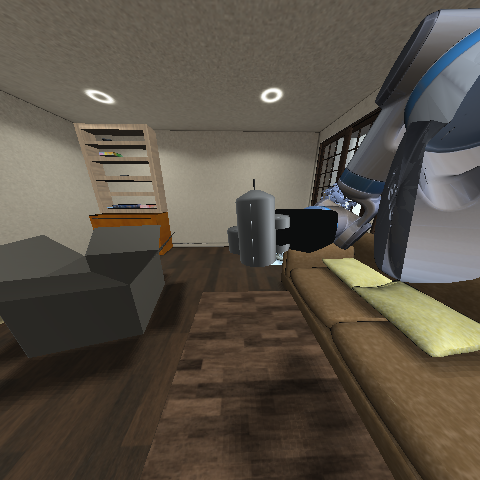

----------------------------------------------------------------------------
Symbolic state: 

reachable {'candle.n.01_1': True, 'table.n.02_1': True}
holding {'candle.n.01_1': True}
is_movable {'candle.n.01_1': True, 'candle.n.01_2': True, 'candle.n.01_3': True, 'candle.n.01_4': True, 'candle.n.01_5': True, 'candle.n.01_6': True}
open {'carton.n.02_1': True, 'carton.n.02_2': True}
ontop {'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
inside {'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
nextto {'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
-------------------------------------

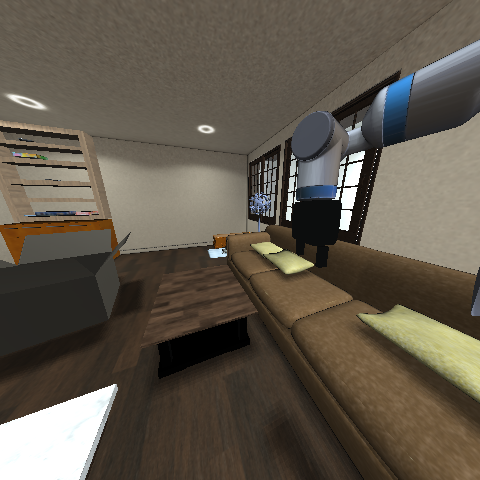

----------------------------------------------------------------------------
Symbolic state: 

reachable {'table.n.02_1': True}
holding {}
is_movable {'candle.n.01_1': True, 'candle.n.01_2': True, 'candle.n.01_3': True, 'candle.n.01_4': True, 'candle.n.01_5': True, 'candle.n.01_6': True}
open {'carton.n.02_1': True, 'carton.n.02_2': True}
ontop {'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
inside {'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
nextto {'candle.n.01_1,table.n.02_1': True, 'candle.n.01_2,carton.n.02_1': True, 'candle.n.01_3,carton.n.02_1': True, 'candle.n.01_4,carton.n.02_2': True, 'candle.n.01_5,carton.n.02_2': True, 'candle.n.01_6,carton.n.02_2': True}
---------------------------------------------

In [9]:
# Parse problem and domain
problem = reader.parse_problem(domain_file, pddl_problem_file)
    
# Make a plan for the problem
with OneshotPlanner(problem_kind=problem.kind) as planner:
    result = planner.solve(problem)

# Check if planner found a plan
if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
    print("Plan found.")
    # Prepare plan in the right format
    plan = [translate_str_to_dict(str(action)) for action in result.plan.actions]
    for action in plan:
        print(action)
else:
    print("No plan found.")
    plan = []

success, detailed_plan_results = execute_plan(sim_env, plan, task, task_instance=0)

Task: packing_food_for_work - Scene id: Beechwood_0_int
Rendering settings is None - going with the default settings!

Looking for plan for pddl/easy/packing_food_for_work.pddl
Plan found.
{'action': 'navigate-to', 'params': ['apple_1']}
{'action': 'grasp', 'params': ['apple_1']}
{'action': 'navigate-to', 'params': ['carton_1']}
{'action': 'place-inside', 'params': ['apple_1', 'carton_1']}
{'action': 'navigate-to', 'params': ['cabinet_1']}
{'action': 'open-container', 'params': ['cabinet_1']}
{'action': 'grasp', 'params': ['snack_food_1']}
{'action': 'navigate-to', 'params': ['carton_1']}
{'action': 'place-inside', 'params': ['snack_food_1', 'carton_1']}
{'action': 'navigate-to', 'params': ['electric_refrigerator_1']}
{'action': 'open-container', 'params': ['electric_refrigerator_1']}
{'action': 'grasp', 'params': ['sandwich_1']}
{'action': 'navigate-to', 'params': ['carton_1']}
{'action': 'place-inside', 'params': ['sandwich_1', 'carton_1']}


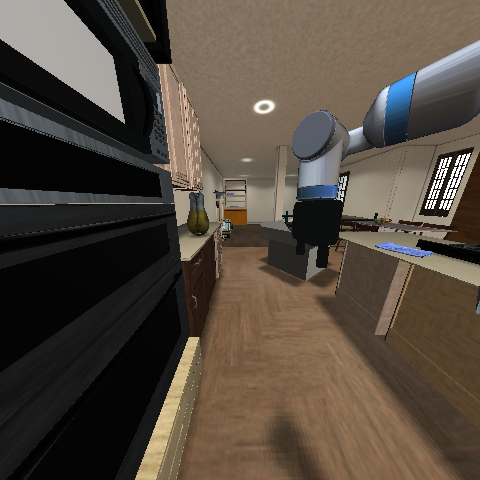

----------------------------------------------------------------------------
Symbolic state: 

reachable {}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True}
holding {}
ontop {'apple.n.01_1,countertop.n.01_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Action {'action': 'navigate-to', 'params': ['apple_1']} executed. Success: True


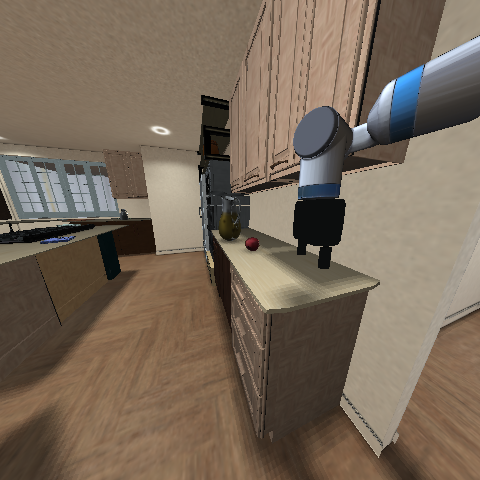

----------------------------------------------------------------------------
Symbolic state: 

reachable {'countertop.n.01_1': True, 'apple.n.01_1': True, 'juice.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True}
holding {}
ontop {'apple.n.01_1,countertop.n.01_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Action {'action': 'grasp', 'params': ['apple_1']} executed. Success: True


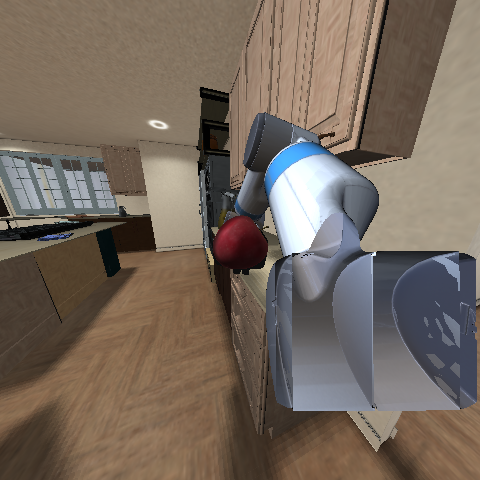

----------------------------------------------------------------------------
Symbolic state: 

reachable {'countertop.n.01_1': True, 'apple.n.01_1': True, 'juice.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True}
holding {'apple.n.01_1': True}
ontop {}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Action {'action': 'navigate-to', 'params': ['carton_1']} executed. Success: True


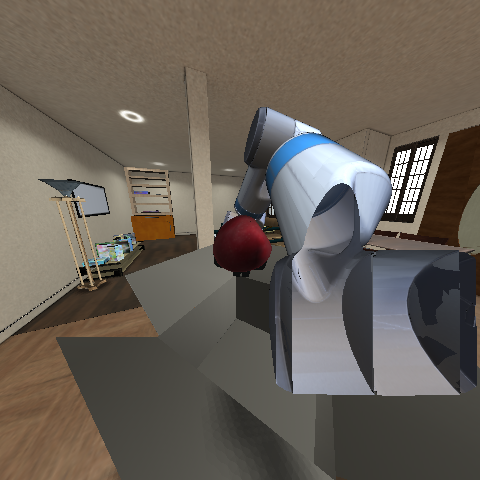

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True, 'apple.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True}
holding {'apple.n.01_1': True}
ontop {}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Action {'action': 'place-inside', 'params': ['apple_1', 'carton_1']} executed. Success: True


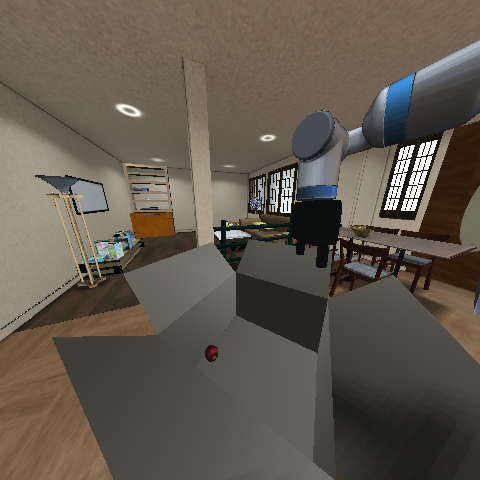

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True, 'apple.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True}
holding {}
ontop {'apple.n.01_1,carton.n.02_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Action {'action': 'navigate-to', 'params': ['cabinet_1']} executed. Success: True


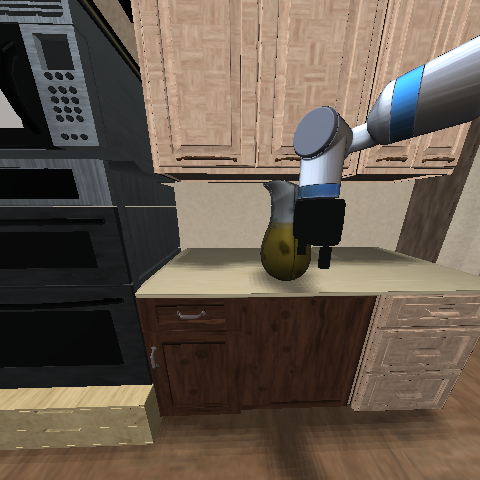

----------------------------------------------------------------------------
Symbolic state: 

reachable {'countertop.n.01_1': True, 'cabinet.n.01_1': True, 'juice.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True}
holding {}
ontop {'apple.n.01_1,carton.n.02_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Action {'action': 'open-container', 'params': ['cabinet_1']} executed. Success: True


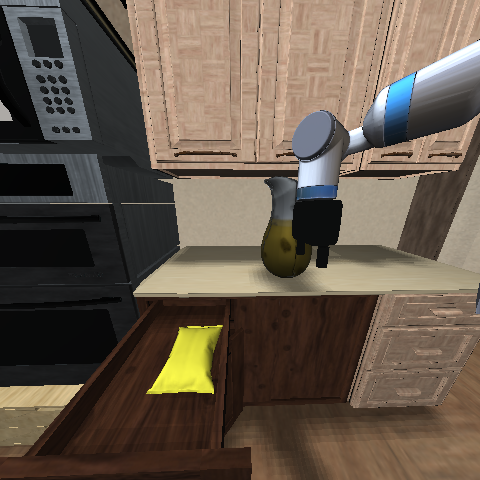

----------------------------------------------------------------------------
Symbolic state: 

reachable {'countertop.n.01_1': True, 'snack_food.n.01_1': True, 'juice.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True, 'cabinet.n.01_1': True}
holding {}
ontop {'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,cabinet.n.01_1': True}
----------------------------------------------------------------------------
Action {'action': 'grasp', 'params': ['snack_food_1']} executed. Success: True


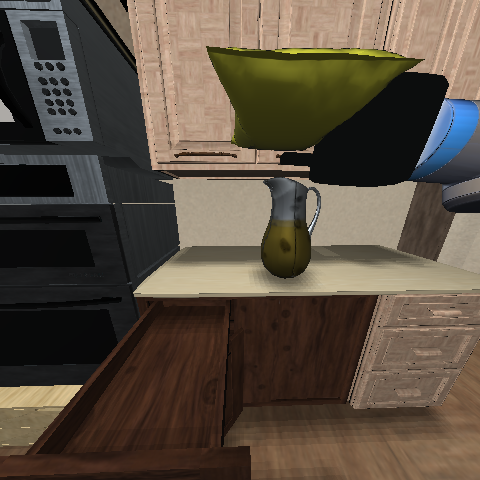

----------------------------------------------------------------------------
Symbolic state: 

reachable {'countertop.n.01_1': True, 'snack_food.n.01_1': True, 'juice.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True, 'cabinet.n.01_1': True}
holding {'snack_food.n.01_1': True}
ontop {'apple.n.01_1,carton.n.02_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True}
----------------------------------------------------------------------------
Action {'action': 'navigate-to', 'params': ['carton_1']} executed. Success: True


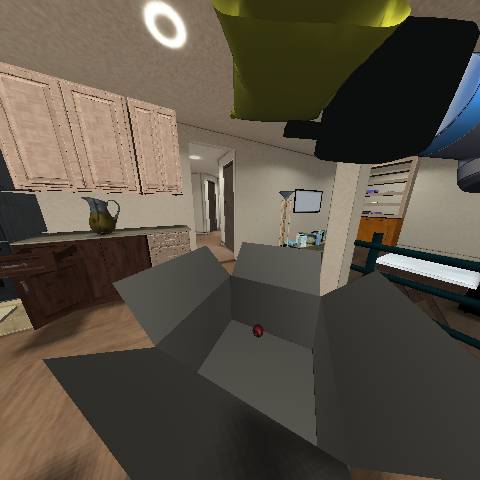

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True, 'snack_food.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True, 'cabinet.n.01_1': True}
holding {'snack_food.n.01_1': True}
ontop {'apple.n.01_1,carton.n.02_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True}
----------------------------------------------------------------------------
Action {'action': 'place-inside', 'params': ['snack_food_1', 'carton_1']} executed. Success: True


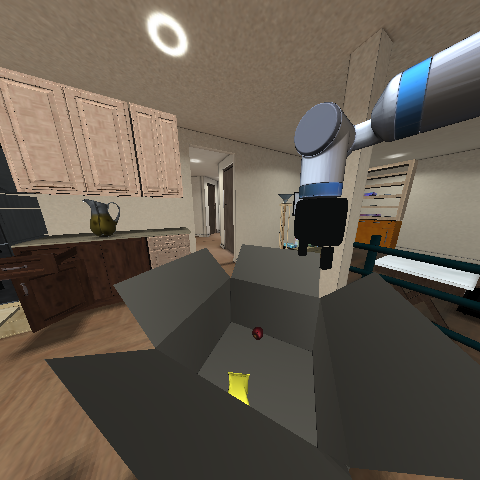

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True, 'snack_food.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True, 'cabinet.n.01_1': True}
holding {}
ontop {'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
----------------------------------------------------------------------------
Action {'action': 'navigate-to', 'params': ['electric_refrigerator_1']} executed. Success: True


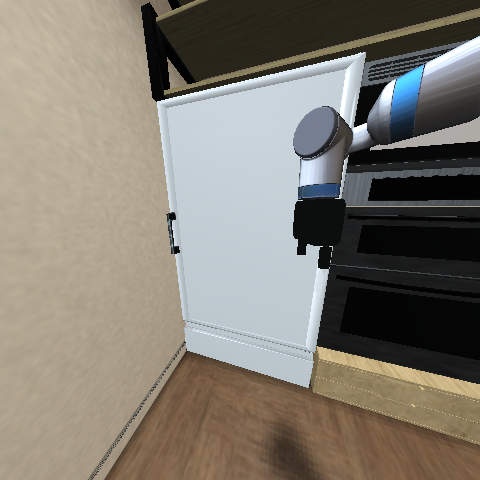

----------------------------------------------------------------------------
Symbolic state: 

reachable {'electric_refrigerator.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True, 'cabinet.n.01_1': True}
holding {}
ontop {'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
----------------------------------------------------------------------------
Action {'action': 'open-container', 'params': ['electric_refrigerator_1']} executed. Success: False


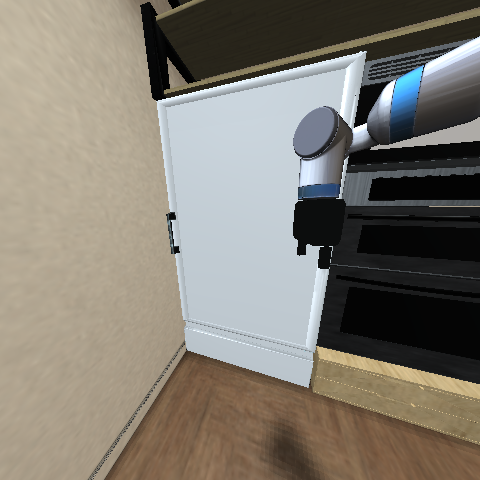

----------------------------------------------------------------------------
Symbolic state: 

reachable {'electric_refrigerator.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True, 'cabinet.n.01_1': True}
holding {}
ontop {'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
----------------------------------------------------------------------------
Preconditions not satisfied. reachable(sandwich.n.01_1)=False ; empty_hand()=True
Action {'action': 'grasp', 'params': ['sandwich_1']} executed. Success: False


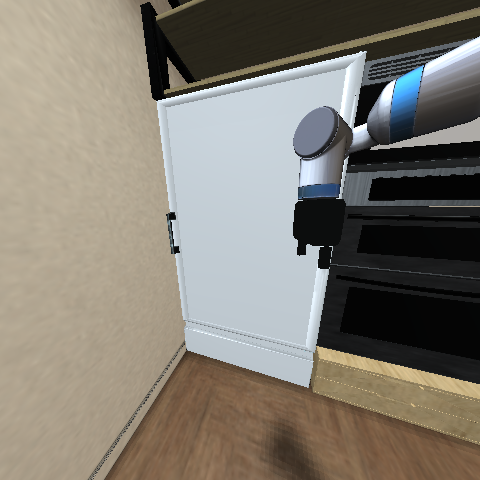

----------------------------------------------------------------------------
Symbolic state: 

reachable {'electric_refrigerator.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True, 'cabinet.n.01_1': True}
holding {}
ontop {'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
----------------------------------------------------------------------------
Action {'action': 'navigate-to', 'params': ['carton_1']} executed. Success: True


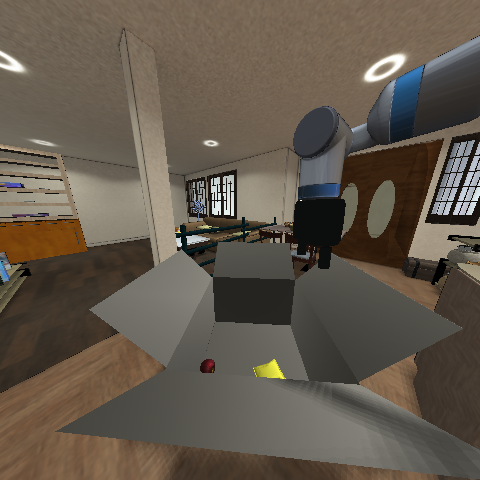

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True, 'cabinet.n.01_1': True}
holding {}
ontop {'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
----------------------------------------------------------------------------
Preconditions not satisfied. reachable=True ; is_open=True ; holding_trg_obj=False
Action {'action': 'place-inside', 'params': ['sandwich_1', 'carton_1']} executed. Success: False


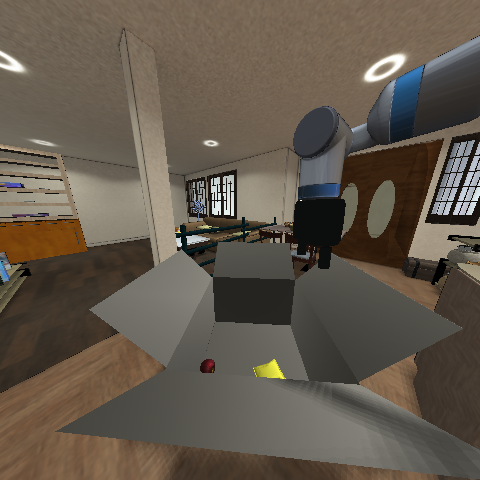

----------------------------------------------------------------------------
Symbolic state: 

reachable {'carton.n.02_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True}
is_movable {'countertop.n.01_1': True, 'sandwich.n.01_1': True, 'apple.n.01_1': True, 'snack_food.n.01_1': True, 'door.n.01_1': True}
open {'carton.n.02_1': True, 'cabinet.n.01_1': True}
holding {}
ontop {'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
inside {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
nextto {'sandwich.n.01_1,electric_refrigerator.n.01_1': True, 'apple.n.01_1,carton.n.02_1': True, 'snack_food.n.01_1,carton.n.02_1': True}
----------------------------------------------------------------------------
Task failed.


In [15]:
reader = PDDLReader()

pddl_dir = 'pddl' 
split_dir = os.path.join(pddl_dir, 'easy')
domain_file = os.path.join(pddl_dir,'domain.pddl')
#test_activity_files = [file for file in os.listdir(split_dir) if file!='.ipynb_checkpoints']
test_activity_files = ['packing_food_for_work.pddl'] # to jump to a specific problem; can also set verbose=True
#test_activity_files = ['opening_presents.pddl', 'opening_packages.pddl']

final_results = {}
for test_activity_file in test_activity_files:
    test_activity_file = os.path.join(split_dir, test_activity_file)

    task, scene_id = get_task_and_scene(test_activity_file)
    if scene_id is not None:
        print(f"Task: {task} - Scene id: {scene_id}")
        # Init env
        sim_env = FetchRobotSemanticActionEnv(task, scene_id, verbose=False)
        
        print(f"\nLooking for plan for {test_activity_file}")
        problem = reader.parse_problem(domain_file, test_activity_file)
        
        # Make a plan for the problem
        with OneshotPlanner(problem_kind=problem.kind) as planner:
            result = planner.solve(problem)
            
        # Check if planner found a plan
        if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
            print("Plan found.")
            # Prepare plan in the right format
            plan = [translate_str_to_dict(str(action)) for action in result.plan.actions]
            for action in plan:
                print(action)
        else:
            print("No plan found.")
            plan = []
        
        success, detailed_plan_results = execute_plan(sim_env, plan)
        if success:
            print("Task solved successfully.")
        else:
            print("Task failed.")
        final_results[task] = {'task_success':success, 'action_success':detailed_plan_results}
    else:
        final_results[task] = None

### Exploration of bddl

In [ ]:
import os
import bddl

In [ ]:
activities = sorted(
        [
            item
            for item in os.listdir(os.path.join(os.path.dirname(bddl.__file__), "activity_definitions"))
            if item != "domain_igibson.bddl"
        ]
    )

assert len(activities)==100, f"Only {len(activities)} activities found."

In [ ]:
os.path.join(os.path.dirname(bddl.__file__), "activity_definitions")

In [ ]:
activities

In [ ]:
domain_file = os.path.join(os.path.dirname(bddl.__file__), "activity_definitions", "domain_igibson.bddl")
with open(domain_file, "r") as f:
    domain = f.read()
    
print(domain)

In [ ]:
predicates_start = domain.find(":predicates")
all_predicates = []
for i, line in enumerate(domain[predicates_start:].split("\n")[1:]):
    if line.strip() == ")":
        break
    predicate = line.strip().split()[0][1:]
    print(f"Predicate {i+1}: {predicate}")
    all_predicates.append(predicate)
    
print(f"Total predicates: {len(all_predicates)}")

In [ ]:
from bddl.parsing import parse_problem, parse_predicates

In [ ]:
def parse_predicates_custom(state, all_predicates, found_predicates=None):
    if found_predicates is None:
        found_predicates = {'known': set(), 'unknown': set()}
        
    for item in state:
        # print(item)
        if item in ['and', 'or', 'not', 'forall', 'exists', 'forpairs', 'forn']:
            continue
        if type(item) == list and len(item) == 1:
            continue
        if item[0].startswith("?"): # Ignore variables (type)
            continue
        if type(item[0]) == str and type(item[1]) == str:
            if item[0] in all_predicates:
                found_predicates['known'].add(item[0])
            else:
                found_predicates['unknown'].add(item[0])
        else:
            parse_predicates_custom(item, all_predicates, found_predicates)
            
    return found_predicates

In [ ]:
activity = activities[5]
print(activity)

problem, objects, initial_state, goal_state = parse_problem(activity, "0", domain_name="igibson")
parse_predicates_custom(goal_state, all_predicates)

In [ ]:
predicates_for_activity = {}

for activity in activities:
    problem, objects, initial_state, goal_state = parse_problem(activity, "0", domain_name="igibson")
    found_predicates = parse_predicates_custom(initial_state, all_predicates)
    found_predicates_for_goal = parse_predicates_custom(goal_state, all_predicates)
    found_predicates['known'] = found_predicates['known'].union(found_predicates_for_goal['known'])
    found_predicates['unknown'] = found_predicates['unknown'].union(found_predicates_for_goal['unknown'])
    predicates_for_activity[activity] = found_predicates

In [ ]:
# Print a global list of predicates (known and unknown), count how many activities they appear in

all_predicates = set()
all_predicates_known = set()


for activity, predicates in predicates_for_activity.items():
    all_predicates.update(predicates['known'])
    all_predicates_known.update(predicates['known'])
    all_predicates.update(predicates['unknown'])
    
predicate_count = {predicate: 0 for predicate in all_predicates}
for activity, predicates in predicates_for_activity.items():
    for predicate in predicates['known']:
        predicate_count[predicate] += 1
    for predicate in predicates['unknown']:
        predicate_count[predicate] += 1
        
predicate_count = {k: v for k, v in sorted(predicate_count.items(), key=lambda item: item[1], reverse=True)}

for predicate, count in predicate_count.items():
    print(f"{predicate} ({'known' if predicate in all_predicates_known else 'unknown'}): {count}")

In [ ]:
predicate_activities = {predicate: [] for predicate in all_predicates}
for activity, predicates in predicates_for_activity.items():
    for predicate in predicates['known']:
        predicate_activities[predicate].append(activity)
    for predicate in predicates['unknown']:
        predicate_activities[predicate].append(activity)
        
for predicate, acts in predicate_activities.items():
    print(f"{predicate}: {acts}")

In [ ]:
from bddl.config import get_definition_filename

In [ ]:
test_activity = activities[5]
print(test_activity)